In [2]:
import numpy as np
from dwave.system import LeapHybridSampler
from dwave.samplers import SimulatedAnnealingSampler
from dimod import ExactCQMSolver

from modules.solvers import QuantumAnnealing

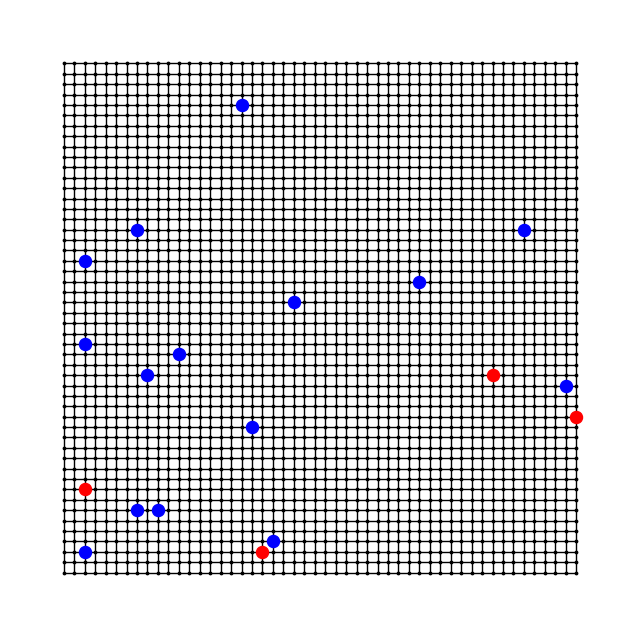

In [4]:
SHAPE = (50,50)
POI = 15
CHARGERS = 4
NEW_CHARGERS = 6

SEED = 42

qa = QuantumAnnealing(SHAPE, POI, CHARGERS, NEW_CHARGERS, seed=SEED)
qa.draw_grid()

Score:  148.3386093659583


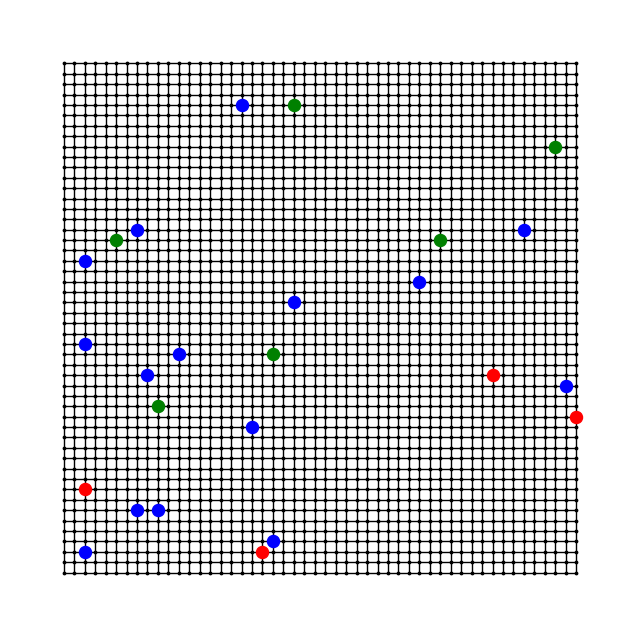

In [5]:
# Build BQM
bqm = qa.build_bqm_numpy()

# Calculate score
sampleset = qa.run_bqm(bqm)
score = qa.score_sampleset(sampleset)

# Create scenario output image
print("Score: ", score)
qa.draw_grid()